In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
import logging
from logging import handlers
from fetch_data import (
    static_population_erva_age,
)
mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
def for_int(u_con, c1, beta, c_gh, T, pop_hat, age_er, t0='2021-04-19'):
    ####################################################################
    # Time periods for epidemic
    T_E = 1./3.
    T_V = 1./10.
    T_I = 1./4.
    T_q0 = 1./5.
    T_q1 = 1./3.
    T_hw = 1./5.
    T_hc = 1./9.
    T_hr = 1.

    # Fraction of nonhospitalized that dies
    mu_q = np.array([0, 0., 0, 0., 0, 0., 0.0, 0.1])
    # Fraction of hospitalized that dies
    mu_w = np.array([0.0, 0.0, 0.00, 0.0, 0.0, 0.0, 0.0, 0.3])
    # Fraction of inds. In critical care that dies
    mu_c = np.array([0.3, 0.1, 0.1, 0.15, 0.15, 0.22, 0.46, 0.5])
    # Fraction of infected needing health care
    p_H = np.array([0, 0, 0.02, 0.03, 0.04, 0.08, 0.16, 0.45])
    # Fraction of hospitalized needing critical care
    p_c = np.array([0, 0, 0, 0, 0, 0.01, 0.03, 0.07])
    alpha = 0.9
    e = 0.95

    # number of age groups
    N_g = 8
    # number of ervas
    N_p = 5
    N_t = T

    # Reading CSV
    epidemic_csv = pd.read_csv('out/epidemic_finland_8.csv')
    # Getting only date t0
    epidemic_zero = epidemic_csv.loc[epidemic_csv['date'] == t0, :]
    # Removing Ahvenanmaa or Aland
    epidemic_zero = epidemic_zero[~epidemic_zero['erva'].str.contains('land')]
    # Droping all the columns we are not using
    epidemic_zero = epidemic_zero.drop(columns=['date', 'erva', 'age', 'First dose', 'Second dose', 'Second dose cumulative', 'infected detected', 'infected undetected'])
    # Converting to numpy
    epidemic_npy = epidemic_zero.values
    # Reshaping to 3d array
    epidemic_npy = epidemic_npy.reshape(N_p, N_g, 5)

    # Allocating space for compartments
    S_g = np.zeros((N_g, N_p, N_t))
    I_g = np.zeros((N_g, N_p, N_t))
    E_g = np.zeros((N_g, N_p, N_t))
    R_g = np.zeros((N_g, N_p, N_t))
    V_g = np.zeros((N_g, N_p, N_t))

    # Adding 1 dimension to age_er to do array division
    age_er_div = age_er[:, :, np.newaxis]
    # Dividing to get the proportion
    epidemic_npy = epidemic_npy/age_er_div

    # Initializing with CSV values
    epidemic_npy = epidemic_npy.transpose(1, 0, 2)
    S_g[:, :, 0] = epidemic_npy[:, :, 0]
    I_g[:, :, 0] = epidemic_npy[:, :, 1]
    E_g[:, :, 0] = epidemic_npy[:, :, 2]
    R_g[:, :, 0] = epidemic_npy[:, :, 3]
    V_g[:, :, 0] = epidemic_npy[:, :, 4]

    # Initializing the rest of compartments to zero
    D_g = np.zeros((N_g, N_p, N_t))
    Q_0g = np.zeros((N_g, N_p, N_t))
    Q_1g = np.zeros((N_g, N_p, N_t))
    H_wg = np.zeros((N_g, N_p, N_t))
    H_cg = np.zeros((N_g, N_p, N_t))
    H_rg = np.zeros((N_g, N_p, N_t))
    S_vg = np.zeros((N_g, N_p, N_t))
    S_xg = np.zeros((N_g, N_p, N_t))

    # I store the values for the force of infection (needed for the adjoint equations)
    L_g = np.zeros((N_g, N_p, N_t))
    # Cummulative number for all age groups and all ervas
    D_d = np.zeros(N_t)

    # Vaccination rate which we set v_{kg}(t) = n_max_{kg}(t)/S_{kg}(t)
    # In equation (1), where n_max_{kg}(t) is the maximum number of daily vaccines
    pop_erva = age_er.sum(axis=1)
    pop_erva_prop = pop_erva/np.sum(pop_erva)
    u_erva = u_con*pop_erva_prop

    u = np.zeros((N_g, N_p, N_t))

    # Forward integration for system of equations (1)
    for j in range(N_t-1):
        D = 0.0
        for n in range(N_p):
            age_group_indicator = N_g-1
            for g in range(N_g-1, -1, -1):
                I_h_force = I_g[:, :, j]
                c_gh_force = c_gh[:, g]
                c_gh_force = c_gh_force[np.newaxis, :]
                mob_k = c1[n, :]
                mob_k = mob_k[:, np.newaxis]

                # Force of infection in equation (4)
                lambda_g = c_gh_force@I_h_force@(c1@mob_k)
                L_g[g, n, j] = lambda_g

                if S_g[g, n, j] - beta*lambda_g*S_g[g, n, j] <= 0:
                    age_group_indicator = age_group_indicator - 1

                if age_group_indicator == g:
                    u[g, n, j] = u_erva[n]/age_er[n, g]

                #u[g,n,j] = w1 n(k,r)/n(r) + w2 I_g[g,n,j]/number of infectious in finalnd + w3 (H_wg[g,n,j] + +)/number of finland
                # Ensures that we do not keep vaccinating after there are no susceptibles left
                u[g, n, j] = min(u[g, n, j], max(0.0, S_g[g, n, j] - beta*lambda_g*S_g[g, n, j]))
                S_g[g, n, j+1] = S_g[g, n, j] - beta*lambda_g*S_g[g, n, j] - u[g, n, j]
                S_vg[g, n, j+1] = S_vg[g, n, j] - beta*lambda_g*S_vg[g, n, j] + u[g, n, j] - T_V*S_vg[g, n, j]
                S_xg[g, n, j+1] = S_xg[g, n, j] - beta*lambda_g*S_xg[g, n, j] + (1.-alpha*e)*T_V*S_vg[g, n, j]
                V_g[g, n, j+1] = V_g[g, n, j] + alpha*e*T_V*S_vg[g, n, j]
                E_g[g, n, j+1] = E_g[g, n, j] + beta*lambda_g*(S_g[g, n, j]+S_vg[g, n, j] +S_xg[g, n, j] ) - T_E*E_g[g, n, j]
                I_g[g, n, j+1] = I_g[g, n, j] + T_E*E_g[g, n, j]- T_I*I_g[g, n, j]
                Q_0g[g, n, j+1] = Q_0g[g, n, j] + (1.-p_H[g])*T_I*I_g[g, n, j] - T_q0*Q_0g[g, n, j]
                Q_1g[g, n, j+1] = Q_1g[g, n, j] + p_H[g]*T_I*I_g[g, n, j] - T_q1*Q_1g[g, n, j]
                H_wg[g, n, j+1] = H_wg[g, n, j] + T_q1*Q_1g[g, n, j] - T_hw*H_wg[g, n, j]
                H_cg[g, n, j+1] = H_cg[g, n, j] + p_c[g]*T_hw*H_wg[g, n, j] - T_hc*H_cg[g, n, j]
                H_rg[g, n, j+1] = H_rg[g, n, j] + (1.-mu_c[g])*T_hc*H_cg[g, n, j] - T_hr*H_rg[g, n, j]   
                R_g[g, n, j+1] = R_g[g, n, j] + T_hr*H_rg[g, n, j] + (1.-mu_w[g])*(1.-p_c[g])*T_hw*H_wg[g, n, j] + (1.-mu_q[g])*T_q0*Q_0g[g, n, j]
                D_g[g, n, j+1] = D_g[g, n, j] + mu_q[g]*T_q0*Q_0g[g, n, j]+mu_w[g]*(1.-p_c[g])*T_hw*H_wg[g, n, j]  + mu_c[g]*T_hc*H_cg[g, n, j]  

                D = D + D_g[g, n, j+1]*age_er[n, g]
        D_d[j] = D

    return S_g, S_vg, S_xg, L_g, D_d, D_g, u

In [3]:
# Contact matrix
c_gh_3 = np.array(([[1.3,0.31,0.23,1.07,0.51,0.16,0.14,0.09],
[0.28,1.39,0.21,0.16,0.87,0.44,0.05,0.04],
[0.19,0.19,0.83,0.26,0.25,0.42,0.18,0.06],
[0.85,0.14,0.25,0.89,0.33,0.31,0.24,0.12],
[0.43,0.8,0.26,0.36,0.72,0.49,0.24,0.17],
[0.12,0.37,0.39,0.3,0.44,0.79,0.25,0.16],
[0.11,0.04,0.17,0.24,0.22,0.25,0.59,0.28],
[0.06,0.03,0.05,0.1,0.13,0.13,0.23,0.55]]))

logger = logging.getLogger()
erva_pop_file = 'stats/erva_population_age_2020.csv'
number_age_groups = 8
num_ervas = 5
pop_ervas_age, _ = static_population_erva_age(logger, erva_pop_file,
                                              number_age_groups=number_age_groups)
pop_ervas_age = pop_ervas_age[~pop_ervas_age['erva'].str.contains('All')]
pop_ervas_age = pop_ervas_age[~pop_ervas_age['erva'].str.contains('land')]
pop_ervas_age = pop_ervas_age.sort_values(['erva', 'age_group'])
pop_ervas_npy = pop_ervas_age['Total'].values
pop_ervas_npy = pop_ervas_npy.reshape(num_ervas, number_age_groups)

ervas_order = ['HYKS', 'TYKS', 'TAYS', 'KYS', 'OYS']
ervas_df = list(pd.unique(pop_ervas_age['erva']))
ervas_pd_order = [ervas_df.index(erva) for erva in ervas_order]
# Rearrange rows in the correct order
age_er = pop_ervas_npy[ervas_pd_order, :]

pop_erva = age_er.sum(axis=1)

# Mobility matrix
m_av = np.array(
            [[1389016, 7688, 16710, 7789, 1774],
            [11316, 518173, 14139, 562, 2870],
            [22928, 12404, 511506, 4360, 1675],
            [8990, 365, 4557, 459867, 3286],
            [1798, 2417, 1592, 3360, 407636]]
       )

m_av = m_av/pop_erva[:, np.newaxis]

N_p = 5
Ng = 8
mob_av = np.zeros((N_p, N_p))
r = 1./3.
for k in range(N_p):
    for m in range(N_p):
        if k == m:
            mob_av[k,m] = (1.-r) + r*m_av[k,m]
        else:
            mob_av[k,m] = r*m_av[k,m]

####################################################################
# Equation (3) in overleaf (change in population size because of mobility) N_hat_{lg}, N_hat_{l}
pop_erva_hat = np.zeros(N_p)
age_er_hat = np.zeros((Ng, N_p))

for m in range(N_p):
    m_k = 0.0
    for k in range(N_p):
        m_k = m_k + pop_erva[k]*mob_av[k,m]
        for g in range(Ng):
            age_er_hat[g, m] = sum(age_er[:, g]*mob_av[:, m])

    pop_erva_hat[m] = m_k

##############################################
# Population size per age group in all ervas
age_pop = sum(age_er)

# Computing beta_gh for force of infection ()
beta_gh = np.zeros((Ng, Ng))

for g in range(Ng):
    for h in range(Ng):
        if g == h:
            for m in range(N_p):
                sum_kg2 = 0.0
                for k in range(N_p):
                    sum_kg2 = sum_kg2 + age_er[k, g]*mob_av[k, m]*mob_av[k, m]/pop_erva_hat[m]
            sum_kg = sum(age_er_hat[g, :]*age_er_hat[h, :]/pop_erva_hat)
            beta_gh[g, h] = age_pop[g]*c_gh_3[g, h]/(sum_kg-sum_kg2)
        else:
            sum_kg = age_er_hat[g, :]*age_er_hat[h, :]
            beta_gh[g, h] = age_pop[g]*c_gh_3[g, h]/(sum(sum_kg/pop_erva_hat))

######################################################################################
# number of ervas
N_p = 5
# number of age groups
Ng = 8
# number of optimization variables
N_f = (Ng-3)*N_p

In [5]:
T = 90
# transmission parameter
beta = 0.02
u = 30000
plot_interval = 15
t0 = '2021-04-19'
ervas_labels = ['HYKS', 'TYKS', 'TAYS', 'KYS', 'OYS']
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

Sg, Svg, Sxg, Lg, D_d, D_g, u_g = for_int(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0)

In [6]:
age_er_prop = age_er.T
age_er_prop = age_er_prop[:, :, np.newaxis]
D_g_plot = D_g*age_er_prop
u_g_plot = u_g*age_er_prop

In [7]:
def plot_ervas(ax, D_g, t0, T, ervas_labels):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ervas == len(ervas_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=0)
    assert deaths.shape[0] == num_ervas
    assert deaths.shape[1] == T
    
    for erva_i in range(num_ervas):
        ax.plot(x, deaths[erva_i, :], label=ervas_labels[erva_i])
        
    ax.legend()

In [8]:
def plot_age_groups(ax, D_g, t0, T, age_labels):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    
    num_ages, num_ervas, days = D_g.shape
    assert num_ages == len(age_labels)
    
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    deaths = D_g.sum(axis=1)
    assert deaths.shape[0] == num_ages
    assert deaths.shape[1] == T
    
    for age_i in range(num_ages):
        ax.plot(x, deaths[age_i, :], label=age_labels[age_i])
        
    ax.legend()

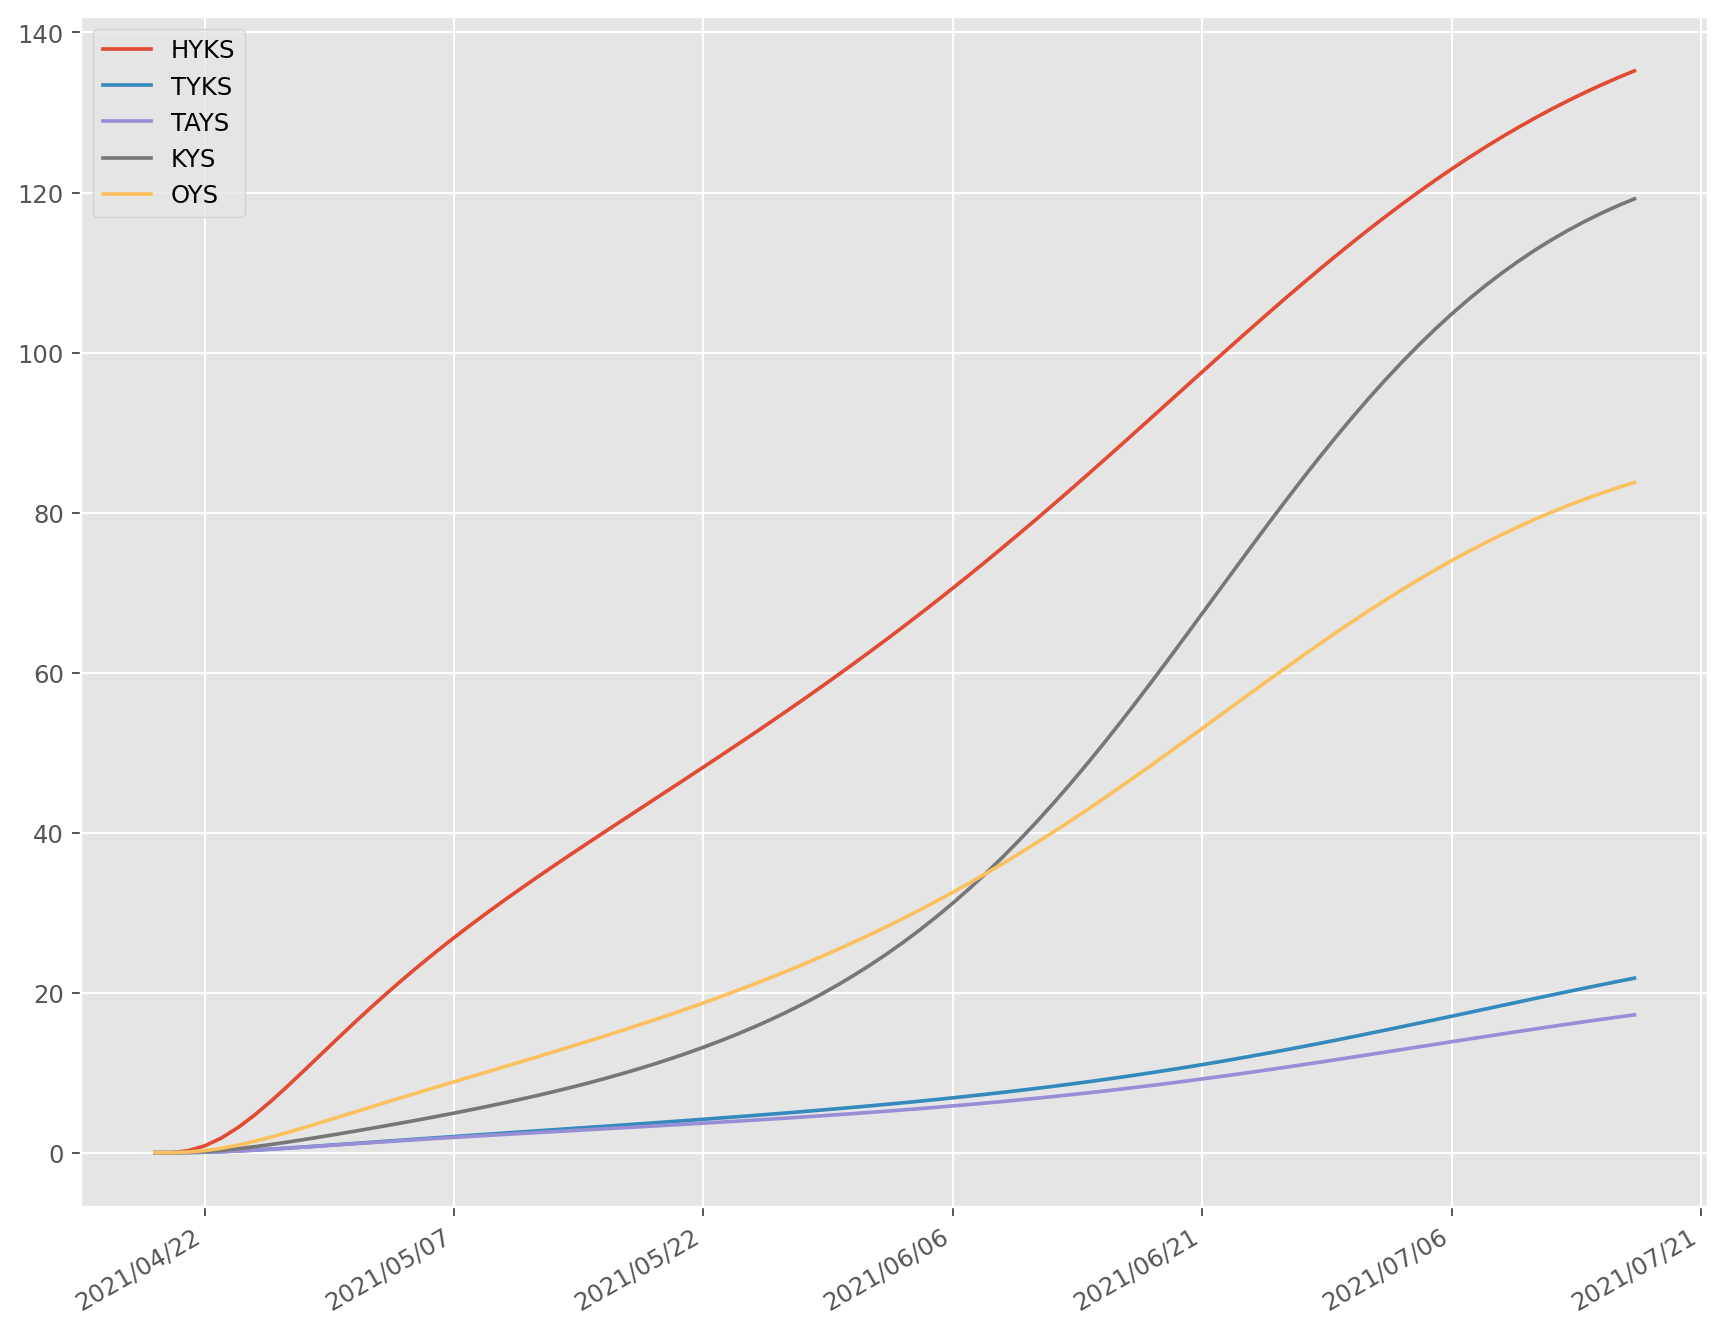

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_ervas(ax=ax, D_g=D_g_plot, t0=t0, T=T, ervas_labels=ervas_labels)

fig.autofmt_xdate()

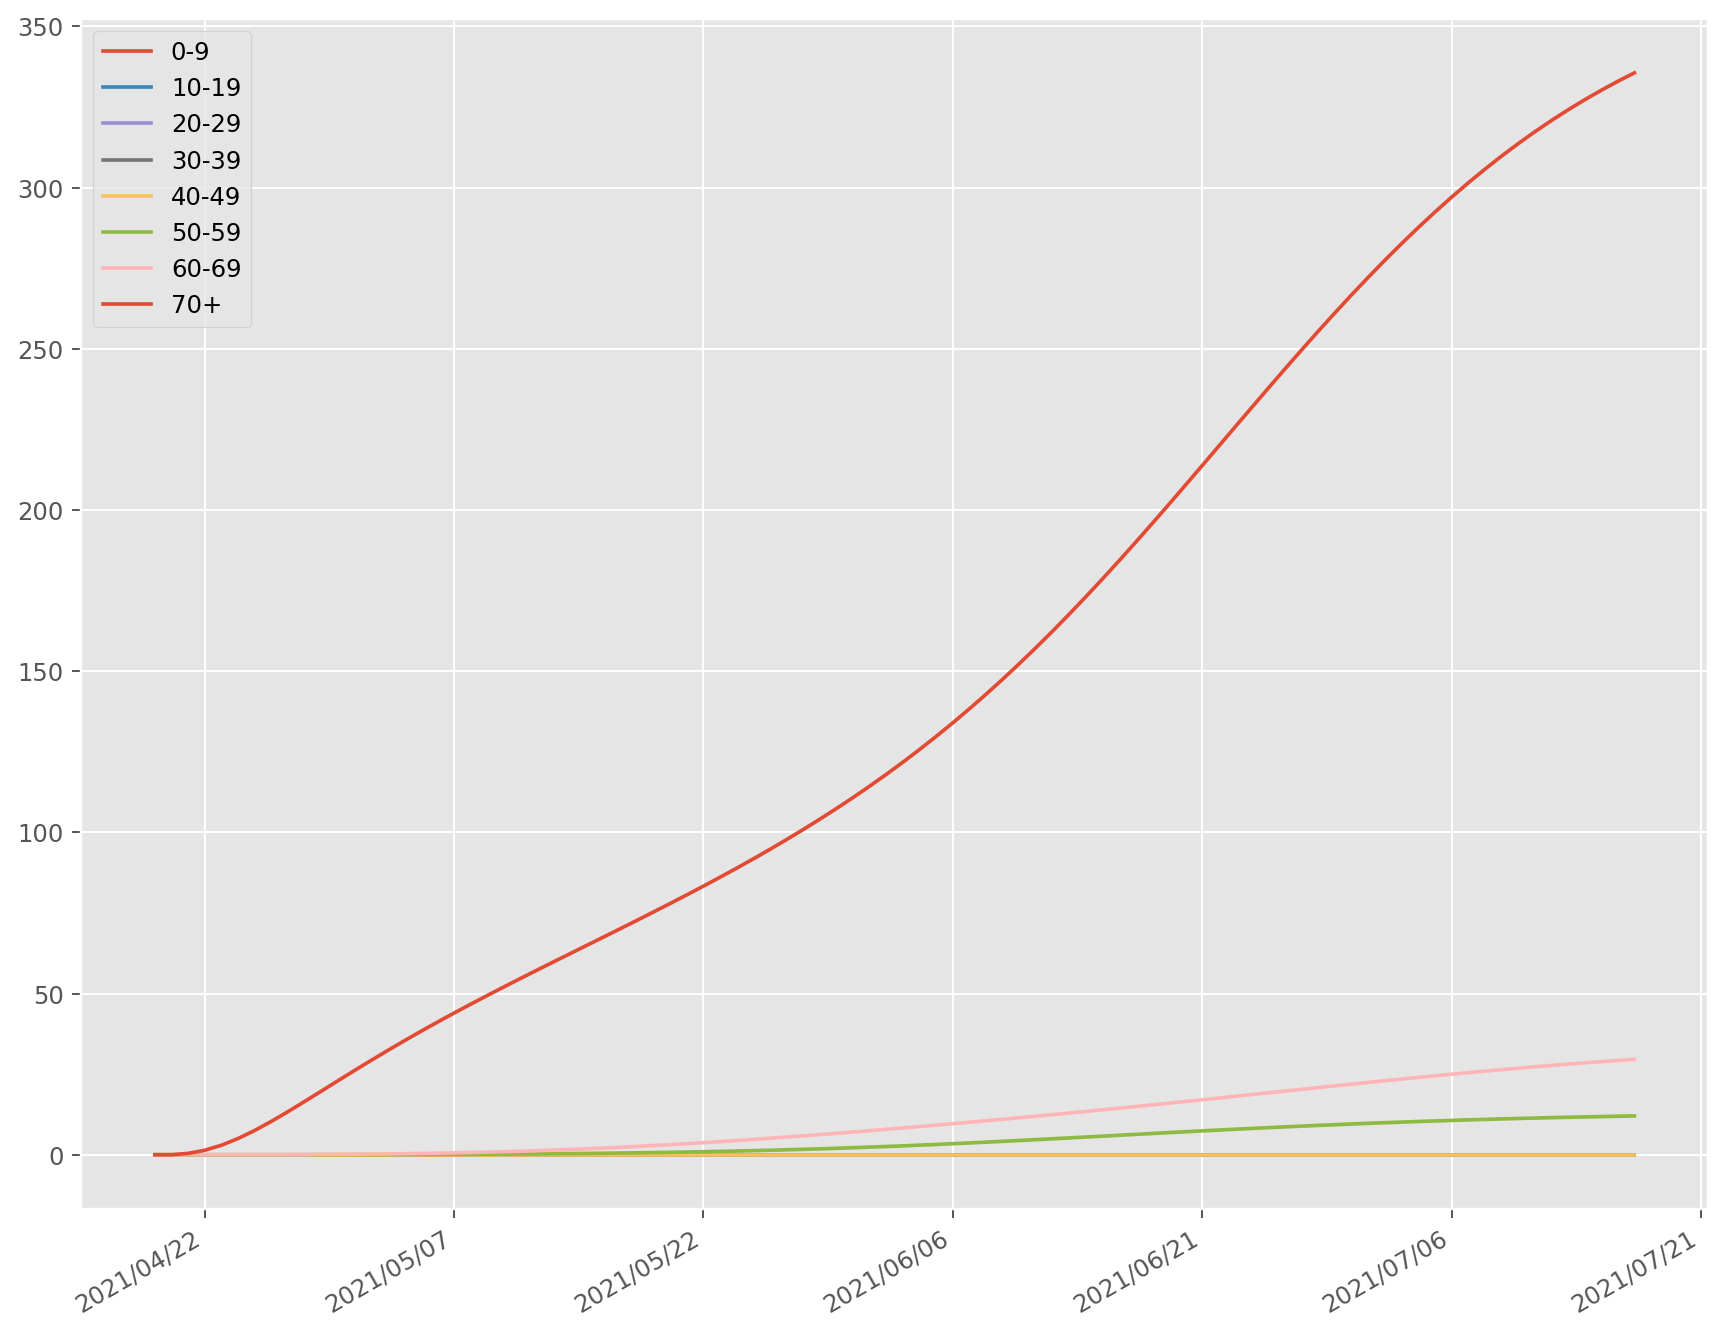

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=D_g_plot, t0=t0, T=T, age_labels=age_labels)

fig.autofmt_xdate()

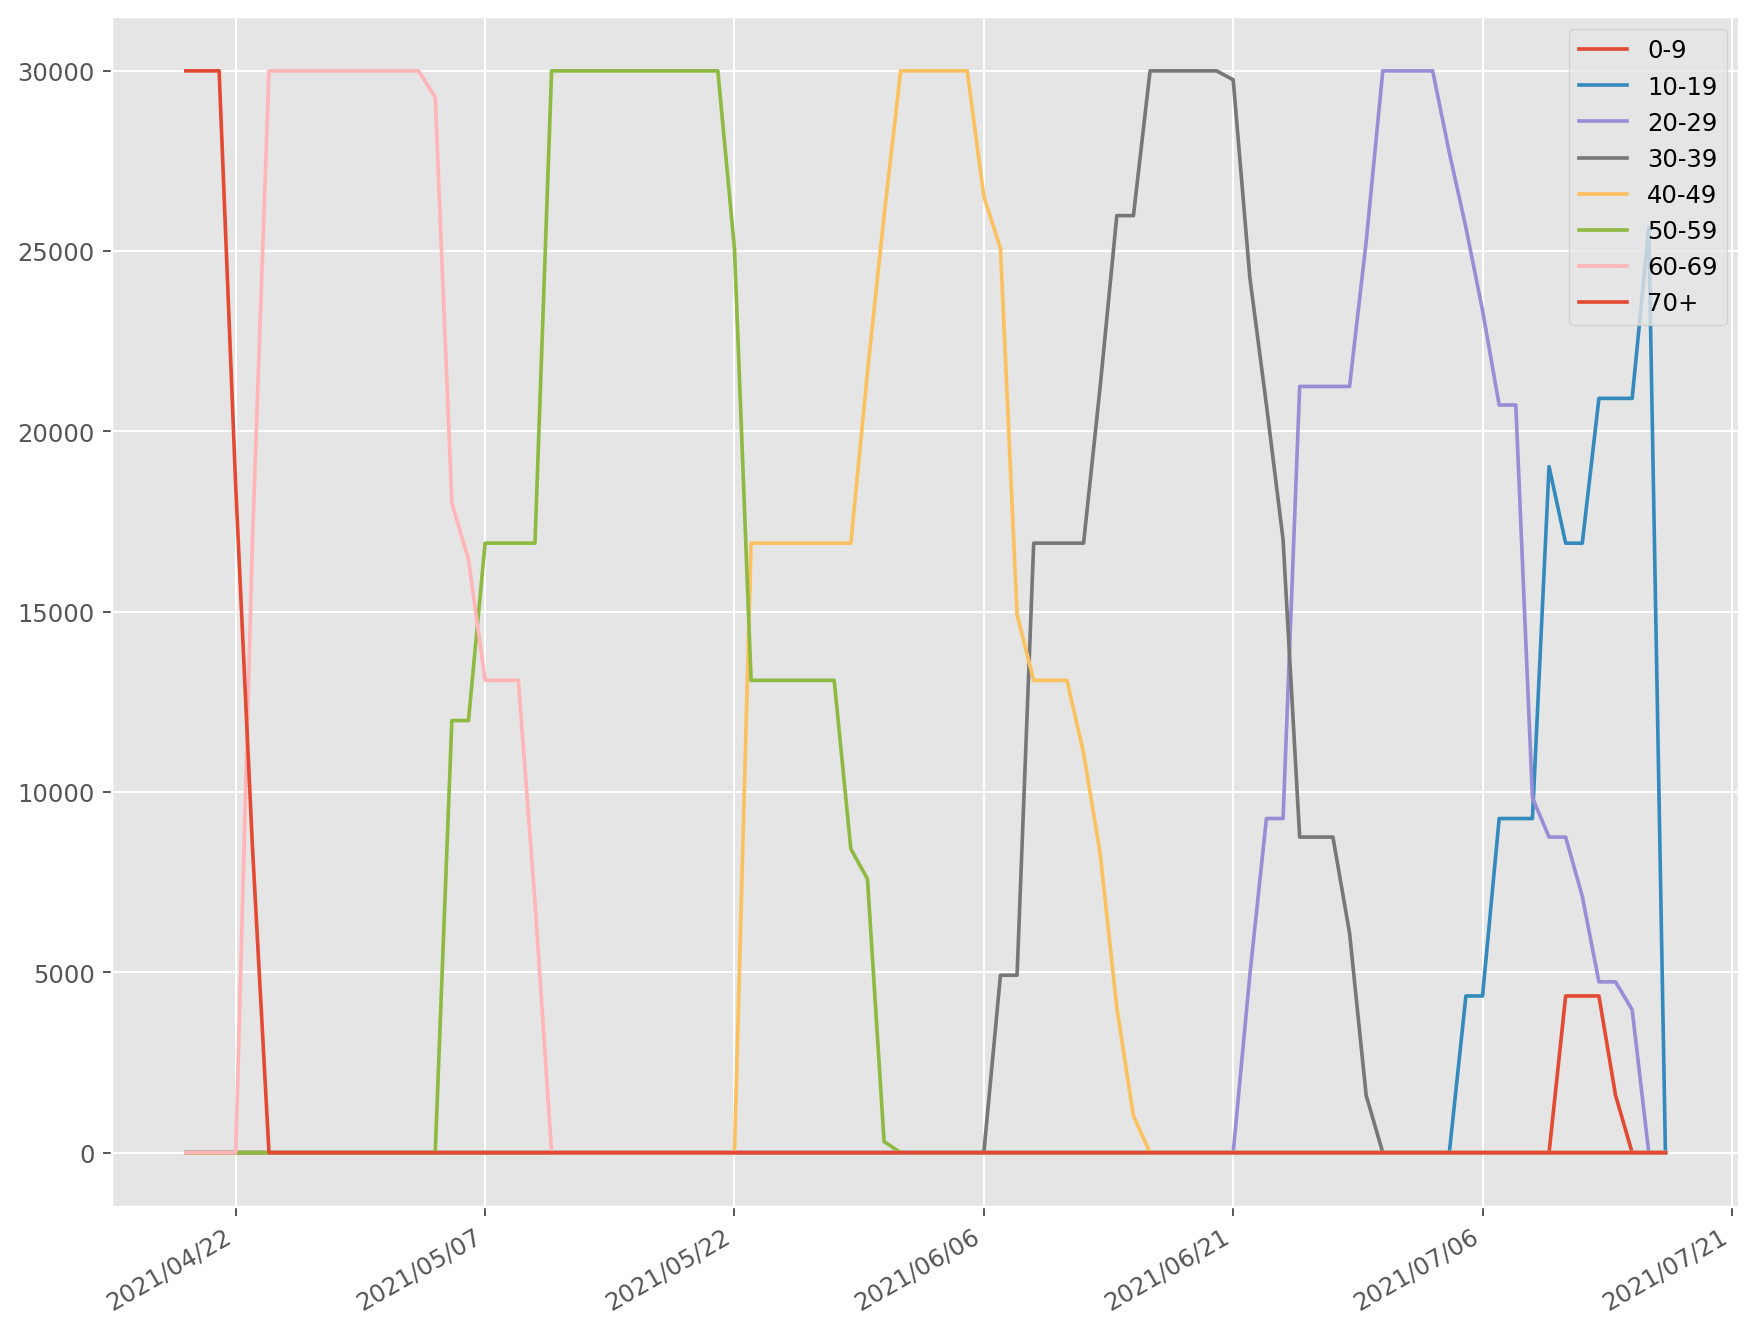

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_age_groups(ax=ax, D_g=u_g_plot, t0=t0, T=T, age_labels=age_labels)

fig.autofmt_xdate()